In [1]:
### Libraries ###
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp1d
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Table of contents
1. [Introduction](#intro)
2. [Section2](#section2)
    1. [subsection](#subsection)





4. Write a Monte Carlo simulation that generates scattering events following the distributions found analytically; 
5. Produce a synthetic dataset of about $N=10^5$ (or more) events. Events should be expressed as rows in a file with columns representing the muons coordinates;
6. Assume a $3$ cm thick Beryllium block is used as a target, and the rate of positrons on the target is $10^6$ Hz. Compute a rescaling factor (weight) you need to apply to each one of the $N$ simulated events such that they represent the statistics that would be gathered in a week of countinuous operations.

In [2]:
## Constants ##

alpha  = 1 / (137.035999084) #  Fine-Structure constant
mu = 105.6583755       # [MeV] Muon mass
me    = 0.51099895        # [MeV] Electron mass
sqr_s      = 250.          # [MeV] Invariant mass  
N =   10**5               # number of muons pair

In [3]:
#Definition of functions

""" Kinematic's formula  """
def b_mu(s):
    return (1 - 4*mu**2/s)**0.5

def b_me(s):
    return (1 - 4*me**2/s)**0.5

def norm(s):
    return (s/4 - mu**2)**0.5

def tan_lab(theta):
    return np.sin(theta) * (1 - b_me(s))**0.5 / (np.cos(theta) + b_me(s)/b_mu(s)) 

def boost_e(s, px):
    return (1 - b_me(s))**0.5 * s + b_me(s) *( 1 - b_me(s))**0.5 * px

def boost_px(s,px):
    return (1 - b_me(s))**0.5 * px + b_me(s) *( 1 - b_me(s))**0.5 * s

""" -----------------------------------------"""

""" Differential cross section formula [MeV^-2 sr^-1] """
def sigma_diff (s,theta):
    return alpha**2/(4*s) * (b_mu(s)/b_me(s)) * (1. + 4.*(me**2 + mu**2)/s + b_me(s)**2 * b_mu(s)**2 * np.cos(theta)**2)

""" Cross section formula [MeV^-2 sr^-1] """
def sigma(s):
    return (4 * alpha**2 * np.pi)/(3 * s**3) * (b_mu(s)/b_me(s)) * (2 * me**2 + s) * (2 * mu**2 + s)

""" Angular distribution formula  """ #Not sure this is the angular distribution formula
def ang(s,theta):
    return 2 * np.pi * np.sin(theta) * sigma_diff(s,theta) / sigma(s)

def g_cdf(s, theta):
    '''CDF for the theta* distribution'''
    
    return (4 * (2 * me**2 + s) * (2 * mu**2 + s) - 3 * s * (4 * me**2 + 4 * mu**2 + s) * np.cos(theta) + (4 * me**2 - s) * (-4 * mu**2 + s) * np.power(np.cos(theta),3)) / \
           (8 * (2 * me**2 + s) * (2 * mu**2 + s))


def gamma_e(s):
        return 1 / np.sqrt(1 - b_me(s)**2)
    
def energy_x_boost(s, x_cm):
    E_cm  = np.sqrt(s) / 2
    gamma = gamma_e(s)
    beta  = b_me(s)
    return (gamma * ( E_cm + beta * x_cm ), gamma * (beta * E_cm + x_cm))
        


## Introduction <a name="introduction"></a>


# Montecarlo with monochromatic beam

The first simulation of the scattering process is based on a monochromatic positron beam, i.e. it has the following characteristics:
- we assume its transversal section to be point-like;
- all the beam particles have the same energy.

In order to sample $\theta$ distributed according to the differential cross section, we will use the inverse transform method. 
Since we know the analytic form of CDF of the angular distribution in the CoM frame $g(\theta^*)$, this approach can be applied and 
leads to better performances. The distribution $h(\varphi^*)$ is infact uniform in the interval [0,$2\pi$]. idly we have:

$$
g(\theta^*) = \frac{2\pi \sin(\theta^*)}{\sigma^*} \cdot \frac{\mathrm{d}\sigma^*}{\mathrm{d}\Omega^*} \quad \quad \text{and} \quad \quad h(\varphi^*) = \frac{1}{2\pi}

$$

The CDF is computed through the following: 

\begin{align}
\text{CDF}[ g(\theta^*)]=  \int_0^{\theta^*} g(\theta^*)  \mathrm{d}\theta^*  
= \int_0^{\theta^*} \frac{2\pi \sin(\theta^*)}{\sigma} \cdot \frac{\alpha^2}{4s} \left(1- \frac{4 m_\mu^2}{s}\right)^{1/2} \left(1- \frac{4 m_e^2}{s}\right)^{-1/2}\left[ 1+ \frac{4}{s} (m_e^2 + m_\mu^2) + \left(1-\frac{4 m_e^2}{s}\right)\left(1-\frac{4 m_\mu^2}{s}\right)\cos^2\theta^*\right]  \\ = 
\frac{2\pi}{\sigma} \frac{\alpha^2}{4s} \left(1- \frac{4 m_\mu^2}{s}\right)^{1/2} \left(1- \frac{4 m_e^2}{s}\right)^{-1/2}
    \cdot \left\{\left[1+ \frac{4}{s} (m_e^2 + m_\mu^2)\right] (1 - \cos\theta^*) + \frac{1}{3}\left(1-\frac{4 m_e^2}{s}\right)\left(1-\frac{4 m_\mu^2}{s}\right)(1 - \cos^3\theta^*)\right\} \tag{0.1}
\end{align}

To generate the events:

$a_i$ random uniform in [0,1] $\implies$ CDF[$g(\theta^*)]^{-1}$($a_i$) =$\theta^*_i \\$ 
$b_i$ random uniform in [0,$2\pi$] $\implies$ CDF[$h(\theta^*)]^{-1}$($b_i$) =$\varphi^*_i $

The inverse of the CDF is computed by interpolation through different methods available in the scipy library, i.e. ``UnivariateSpline``, ``InterpolatedUnivariateSpline`` and ``interp1d``.


In [4]:
def g_cdf(s, theta):
    '''CDF for the theta* distribution'''
    
    return (4 * (2 * me**2 + s) * (2 * mu**2 + s) - 3 * s * (4 * me**2 + 4 * mu**2 + s) * np.cos(theta) + (4 * me**2 - s) * (-4 * mu**2 + s) * np.power(np.cos(theta),3)) / \
           (8 * (2 * me**2 + s) * (2 * mu**2 + s))

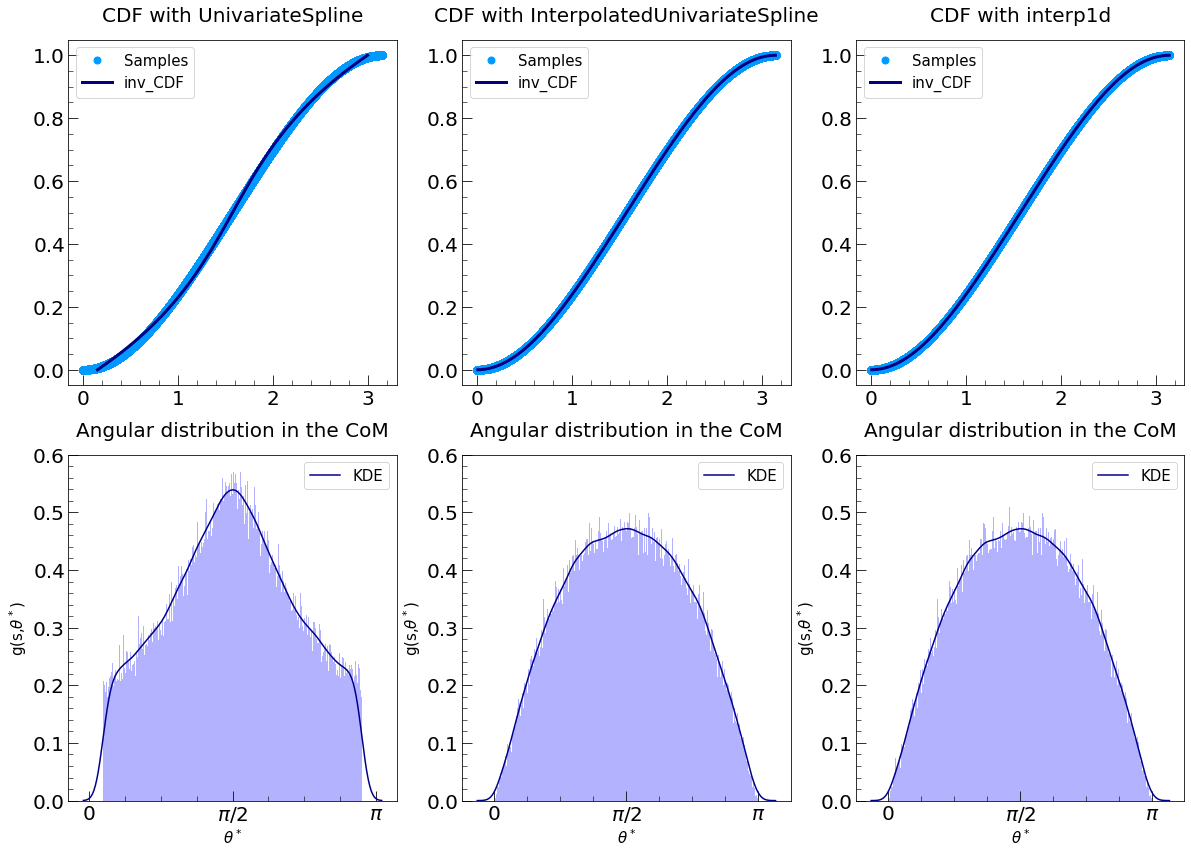

In [5]:
fig, ax = plt.subplots(2,3, figsize = (20,14))

# Angles in the CoM frame on which we sample the inverse CDF
theta_star = np.linspace(0, np.pi, N)

s = sqr_s**2 

# three version of inverse CDF sampling
inv_cdf1 = UnivariateSpline(g_cdf(s,theta_star),theta_star, ext=0)
inv_cdf2 = InterpolatedUnivariateSpline(g_cdf(s,theta_star),theta_star, ext=0)
inv_cdf3 = interp1d(g_cdf(s, theta_star), theta_star, fill_value='extrapolate') #'extrapolate' is needed for the points at z=0,1, which are 'very slightly' outside of the samples
    
# Sample some angles
num_samples = N
unif_samples = np.random.uniform(size=num_samples)
samples_sorted = np.sort(unif_samples)

phis = np.random.uniform(0, 2 * np.pi, size=num_samples)

#same plot on each ax of the points
for i in range(3):
    ax[0][i].plot(theta_star,g_cdf(s,theta_star),'o',markersize= 7,color = '#009AFF',label='Samples')
    ax[1][i].set_title('Angular distribution in the CoM', pad = 18, fontsize=20)
    ax[1][i].set_ylim(0,0.6)
    ax[1][i].set_xticks([0,np.pi/2,np.pi],['0','$\\pi/2$','$\\pi$'] )
    ax[1][i].set_xlabel('$\\theta^*$',fontsize = 15)
    ax[1][i].set_ylabel('g(s,$\\theta^*$)',fontsize = 15)   


### UnivariateSpline ###
ax[0][0].set_title('CDF with UnivariateSpline', pad = 18, fontsize=20)
ax[0][0].plot(inv_cdf1(samples_sorted),samples_sorted,color = 'navy',label = 'inv_CDF',linewidth = 3) 
sns.distplot(inv_cdf1(samples_sorted), ax = ax[1][0],kde = True, kde_kws  = {'label': 'KDE',  'color': 'darkblue'},hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'}, bins = int(np.sqrt(N)))


### InterpolatedUnivariateSpline ###
ax[0][1].set_title('CDF with InterpolatedUnivariateSpline', pad = 18, fontsize=20)
ax[0][1].plot(inv_cdf2(samples_sorted),samples_sorted,color = 'navy',label = 'inv_CDF',linewidth = 3) 
sns.distplot(inv_cdf2(samples_sorted), ax = ax[1][1],kde = True, kde_kws  = {'label': 'KDE',  'color': 'darkblue'},hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'}, bins = int(np.sqrt(N)))

### interp1d ###
ax[0][2].set_title('CDF with interp1d', pad = 18, fontsize=20)
ax[0][2].plot(inv_cdf3(samples_sorted),samples_sorted,color = 'navy',label = 'inv_CDF',linewidth = 3) 
sns.distplot(inv_cdf3(samples_sorted), ax = ax[1][2],kde = True, kde_kws  = {'label': 'KDE',  'color': 'darkblue'},hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},bins = int(np.sqrt(N)))

for ax in fig.get_axes():
    # plot settings                    
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=15)
    
plt.show()


Different interpolating functions lead to different distribution: in particular the ``InterpolatedUnivariateSpline``method is not able to fit the extremes providing a wrong angular distribution. 
We then decide to use the ``interp1d`` method. 

In order to generate the scattering events we definie a routine that is implemented in the function `generate_beam`, which returns the two muons 3-momenta in the laboratory frame. 

In [6]:
def generate_beam(sqr_s, batch_size = 10**5):
    '''Function that generates one batch of scattering events
    
    Parameters:

    sqr_s : Center of mass energy (sqrt(s)) in MeV (must be > 2 mu)
           
    batch_size : Number of events in one batch


    Returns: 
    ndarray of size (batch_size, 6)
    Each row is one event, and contains the components of the 3-momenta (in the laboratory frame)
     of the muon-antimuon pair, in [MeV/c]
     
    '''
    
    assert sqr_s > 2 * mu, 'There is not enough energy for muon pair production'
    s = sqr_s**2 

    pnorm = norm(s) # Norm of muon 3-momentum in CM
    
    # Compute inverse CDF of g(theta*) by interpolation 
    theta_star = np.linspace(0, np.pi, N)
    inv_cdf = interp1d(g_cdf(s, theta_star), theta_star, fill_value='extrapolate')

    # Sample angles
    num_samples = N
    unif_samples = np.random.uniform(size=batch_size)

    phis = np.random.uniform(0, 2 * np.pi, size=batch_size)
    thetas = inv_cdf(unif_samples)
    
    
    # Compute cartesian components of 3-vector
    px_cm = pnorm * np.cos(thetas)
    py_cm = pnorm * np.sin(thetas) * np.cos(phis)
    pz_cm = pnorm * np.sin(thetas) * np.sin(phis)


    _,px1 = energy_x_boost(s, px_cm)  # px for first muon
    _,px2 = energy_x_boost(s, -px_cm) # px for second muon
    # py and pz are orthogonal to boost axis, and so they remain the same
    
    return np.stack((px1, py_cm, pz_cm, px2, -py_cm, -pz_cm), axis=1)    




In [7]:
# generate events 
events = generate_beam(250, 10**5)
# save events in txt file and dataframe 
np.savetxt('Momenta_monochromatic.txt', events) # save to file
df_monochromatic = pd.DataFrame(events, columns = [  '$px_{\mu_1}$','$py_{\mu_1}$','$pz_{\mu_1}$','$px_{\mu_2}$','$py_{\mu_2}$','$pz_{\mu_2}$'])
df_monochromatic.to_csv('Events.csv')
df_monochromatic

,$px_{\mu_1}$,$py_{\mu_1}$,$pz_{\mu_1}$,$px_{\mu_2}$,$py_{\mu_2}$,$pz_{\mu_2}$
0,18671.246347,2.864869,45.653350,42482.967138,-2.864869,-45.653350
1,15428.504976,19.757304,-15.360961,45725.708509,-19.757304,15.360961
2,14427.943408,-9.796971,2.645322,46726.270077,9.796971,-2.645322
3,22974.892536,-42.303077,-41.302887,38179.320949,42.303077,41.302887
4,24937.293315,57.717520,-24.463014,36216.920170,-57.717520,24.463014
...,...,...,...,...,...,...
99995,23412.727525,-48.990889,-34.690318,37741.485959,48.990889,34.690318
99996,45794.402342,20.213809,-13.522293,15359.811143,-20.213809,13.522293
99997,35539.231076,4.555017,-63.474982,25614.982409,-4.555017,63.474982
99998,16798.706469,15.629199,-32.317477,44355.507016,-15.629199,32.317477


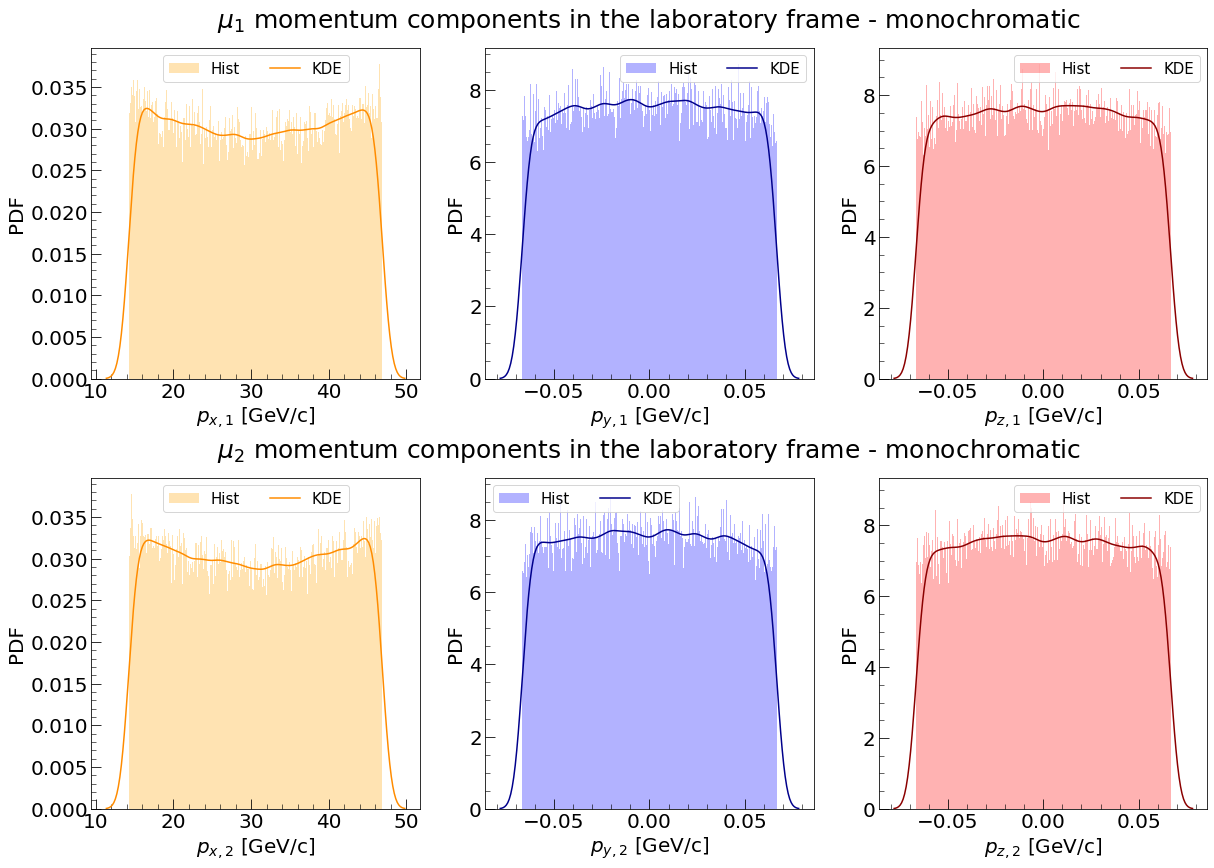

In [8]:
fig, ax = plt.subplots(2,3, figsize = (20,14))

#plotting momentum components distribution in the LAB frame


### MUON 1 ###
# px
sns.distplot(df_monochromatic['$px_{\mu_1}$']/1000,
             ax = ax[0][0],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkorange',   'label': 'KDE'},
             hist_kws = {'color': 'orange', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )

            
# py
sns.distplot(df_monochromatic['$py_{\mu_1}$']/1000,
             ax = ax[0][1],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkblue',   'label': 'KDE'},
             hist_kws = {'color': 'blue', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )
            
# pz
sns.distplot(df_monochromatic['$pz_{\mu_1}$']/1000,
             ax = ax[0][2],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkred',   'label': 'KDE'},
             hist_kws = {'color': 'red', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
            )


ax[0][0].set_xlabel(r'$p_{x,1}$ [GeV/c]',fontsize = 20)
ax[0][1].set_xlabel(r'$p_{y,1}$ [GeV/c]',fontsize = 20)
ax[0][2].set_xlabel(r'$p_{z,1}$ [GeV/c]',fontsize = 20)

ax[0][1].set_title('$\mu_1$ momentum components in the laboratory frame - monochromatic',fontsize = 25,pad = 20)


### MUON 2 ###
# px
sns.distplot(df_monochromatic['$px_{\mu_2}$']/1000,
             ax = ax[1][0],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkorange',   'label': 'KDE'},
             hist_kws = {'color': 'orange', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )
            
# py
sns.distplot(df_monochromatic['$py_{\mu_2}$']/1000,
             ax = ax[1][1],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws = {'color':'darkblue','label':'KDE'},
             hist_kws = {'color': 'blue', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )
            
# pz
sns.distplot(df_monochromatic['$pz_{\mu_2}$']/1000,
             ax = ax[1][2],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkred', 'label':'KDE'},
             hist_kws = {'color': 'red', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
            )


ax[1][0].set_xlabel(r'$p_{x,2}$ [GeV/c]',fontsize = 20)
ax[1][1].set_xlabel(r'$p_{y,2}$ [GeV/c]',fontsize = 20)
ax[1][2].set_xlabel(r'$p_{z,2}$ [GeV/c]',fontsize = 20)

ax[1][1].set_title('$\mu_2$ momentum components in the laboratory frame - monochromatic',fontsize = 25, pad = 20)

for ax in fig.get_axes():
    # plot settings   
    ax.set_ylabel('PDF',fontsize = 20)                   
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=15, ncol = 2)


plt.subplots_adjust(hspace=.3)
plt.show()



The momentum y and z components show a uniform distribution, centered in zero, as expected. On the other hand the x component distribution presents a negative concavity
with peaks at the extremes of the interval. In order to analyze how this distribution changes according to the inveriant mass, we generate events with 
$\sqrt{s}$ = $2m_{\mu} + \epsilon$, where $\epsilon$ is a quantity that will be varied in a certain range.

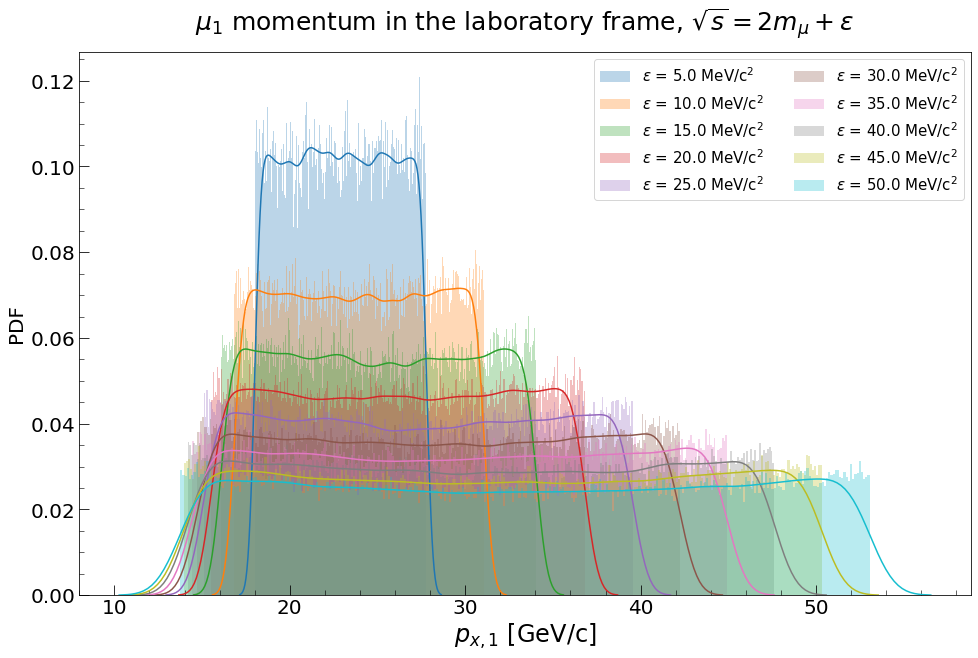

In [9]:
### P_x distribution in function of available energy ###
epsilon = 0.1

for i in range(1,11):
    epsilon = i*5
    sqr_s = 2*mu + epsilon
    events = generate_beam(sqr_s, 10**5)
    globals()[f'df{i}'] = pd.DataFrame(events, columns = [ '$px_{\mu_1}$','$py_{\mu_1}$','$pz_{\mu_1}$','$px_{\mu_2}$','$py_{\mu_2}$','$pz_{\mu_2}$'])


fig, ax = plt.subplots(1,1, figsize = (16,10))

# plotting momentum components distribution in the LAB frame

for i in range(1,11):
    epsilon = 5*i
    sns.distplot(globals()[f'df{i}']['$px_{\mu_1}$']/1000,
                ax = ax,
                bins = int(np.sqrt(N)),
                kde = True,
                #kde_kws  = {'color': 'darkorange',   'label': 'KDE'},
                hist_kws = { 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': '$\epsilon$ = {:.1f} MeV/c$^2$'.format(epsilon)}
                )

ax.set_xlabel(r'$p_{x,1}$ [GeV/c]',fontsize = 24)
ax.set_title('$\mu_1$ momentum in the laboratory frame, $\sqrt{s}=2m_{\mu}+\epsilon$',fontsize = 25,pad = 20)

for ax in fig.get_axes():
    # plot settings   
    ax.set_ylabel('PDF',fontsize = 20)                   
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=15, ncol = 2)

plt.show()

# Berilium target 

The number of $\mu^+ \mu^-$ pairs produced per positron bunch on target is given by:
$$n_\mu =  n_+ \rho^- l_t \sigma $$
where $n_+$ is the number of positrons in the bunch, $\rho^-$ is the electron density in the medium, $l_t$ is the thickness of the target, and $\sigma$ is the total cross section for the $e^+ e^- \to \mu^+ \mu^-$ process.
We can then express it as a function of the impinging positrons rate $f_+$, which reads:
$$f_\mu =  f_+ \rho^- l_t \sigma $$

 $\rho^-$ can be computed as:
$$ \rho^- = N_A \frac{\rho_{\mathrm{Be}}}{M_t} Z $$
with $\rho_{\mathrm{Be}}$ being the target's density, $M_t$ its molar mass, and $Z$ its atomic number. [cite LEMMA article]

So, if we generate $N$ events, the correct statistics for an experiment carried out for a time interval $\Delta T$ can be computed by rescaling histograms by a factor $W = f_\mu \Delta T / N$, with $\Delta T$ in seconds.

Muon pairs produced per second:  2.9871179246970954
Muon pairs produced in a week:  1806608.9208568032


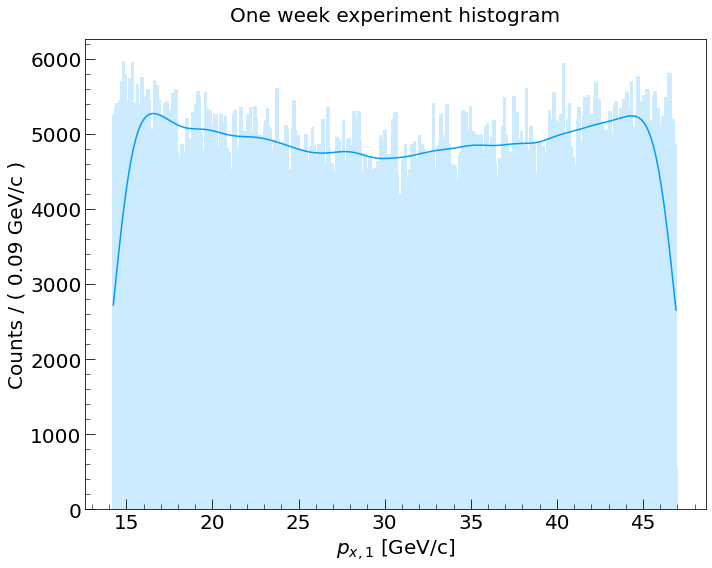

In [10]:

s = 250**2 

cross_sec = sigma(s) * 389.4 * 1e-24 # Total cross section [cm^2]

freq    = 1e6       # Positrons rate on target [Hz]
rhoBe = 1.848       # Beryllium density     [g/cm^3]
MBe   = 9.012       # Beryllium molar mass  [g/mol]
ZBe   = 4           # Beryllium atomic number
lt    = 6           # Target thickness      [cm]
N_a    = 6.022e23   # Avogadro's number     [mol^-1]


T     = 3600 * 24 * 7   # seconds in a week

rho_electrons = N_a * rhoBe * ZBe / MBe         # Be Electron density [n.e-/cm^3]
fmu    = freq * rho_electrons * lt * cross_sec  # Rate of produced muon pairs [Hz]
N_week = fmu * T                                # Number of muons produced in a week (rescaling factor)


print("Muon pairs produced per second: ", fmu)
print("Muon pairs produced in a week: ", N_week)


weights = np.full(int((N)), N_week/N)                     # array of rescaling factors
df_monochromatic['weights']=weights  


fig, ax = plt.subplots(1, figsize = (10,8))

sns.histplot(x=df_monochromatic['$px_{\mu_1}$']/1000,
             ax=ax,
             stat='count',
             weights= df_monochromatic['weights'], 
             bins = int(np.sqrt(N)), 
             kde=True,
             lw=2,
             edgecolor   = "#ccebff",
             color       = "#009CFF",
             binwidth = 0.09
              )


ax.set_title("One week experiment histogram",fontsize = 20, pad = 18)
ax.set_xlabel(r'$p_{x,1}$ [GeV/c]',fontsize = 20)

# plot settings   
ax.set_ylabel('Counts / ( 0.09 GeV/c )',fontsize = 20)                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()


fig.tight_layout()
plt.show()

8. Given that the electrons traversing the target lose energy ($E(x)=E_0 \exp{-x/X_0}$), with $z$ the longitudinal coordinate of the target, 
the one parallel to the beam direction and $X_0$ is the Beryllium radiation length), compute the
nominal beam energy $E_0$ such that muon pairs can be generated along the whole length of the target. 

The threshold energy for muon production in the laboratory frame should be slightly higher than the sum of the two 
muons masses:

$$ \sqrt{s}_{\text{th}} \sim 2m_{\mu} \implies s_{\text{th}} \sim 4m_{\mu}^2 $$

Assuming the target's electrons at rest, we can express $s$ as follows:

$$     s = (p_{e^+}+p_{e^-})^2 = \vec p_{e_+}^2+m_{e_-}^2+m_{e_-}^2+2E_{e_+}m_{e_-}-\vec p_{e_+}^2     $$

Hence, the threshold production condition reads:

$$  E_{e^+,th} > \frac{4m_{\mu}^2 - 2m_{e^-}^2   }{2m_{e^-}} \sim 43.7~\text{GeV} $$

So, with the purpose of having a threshold energy along the whole target we need to impose the same condition at the end
of the latter, i.e. at $x_{max}=l=3$ cm where $l$ is the lenght of the target. 

$$ E_{e^+,th}(x) = E_{e^+,0} \cdot \text{e}^{-l/X_0}  \implies E_{e^+,0} > \frac{4m_{\mu}^2 - 2m_{e^-}^2   }{2m_{e^-}} \cdot \text{e}^{l/X_0} \sim 47.6~\text{GeV} $$

In [11]:
np.sqrt(2*me**2 + 2*49.541*me*1000)


225.01404445890438

Threshold energy: 47571.03 MeV


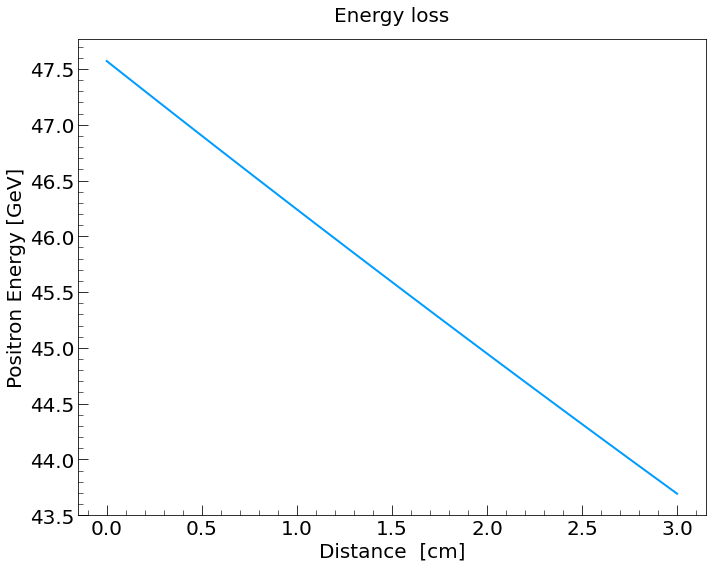

In [12]:
rad_length = 35.28  # Radiation length of Beryllium [cm]
l = 3               # Target thickness [cm]

E_0th = ( (4*mu**2-2*me**2)/(2*me) )*np.exp(l/rad_length)

print ('Threshold energy: {:.2f} MeV'.format(E_0th)) 

### Plot of energy loss in Beryllium ###

x = np.linspace(0,3,100) # distances from 0 to 3 cm 
e = E_0th * np.exp(-x/rad_length) * 1e-03

fig, ax = plt.subplots(1, figsize = (10,8))
ax.plot(x,e, lw=2, ls='-', color = '#009CFF', )

ax.set_title('Energy loss' ,fontsize = 20, pad = 18)
ax.set_xlabel('Distance  [cm]',fontsize = 20)
ax.set_ylabel('Positron Energy [GeV]',fontsize = 20)                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()

fig.tight_layout()
plt.show()


The energy loss in Beryllium is not significant as the exponential trend is not visible from the plot. Indeed along the 
3 cm target, the positrons lose in average roughly 0.4 GeV. This aspect can be further analyzed by comparing the energy loss
trend in different materials. Therefore, we consider a some elements, e.g. Litium, Carbon, Iron. 

Put reference to https://pdg.lbl.gov/2021/AtomicNuclearProperties/

In [13]:
# Build a dataframe with some material and corresponding properties

Material = [   'Li',  'Be',    'B',    'C',     'Al',   'Fe',   'Cu',   'W',    'Pb']        # Material 
Z        = [   3,     4,       5,      6,    13,     26,      29,     74,     82]            # Atomic number  
M        = [ 6.941, 9.01218, 10.811, 12.0107,  26.9815, 55.6934,63.546, 183.84, 207.2]       # Molar mass [g/mol]
density  = [ 0.5340, 1.8477 , 2.370,   2.0,   2.699 ,   7.874 ,  8.96,   19.3 ,  11.35]      # Density [g/cm^3]
X0       = [ 155.0, 35.28,    22.23,   21.35, 8.897 ,  1.757,   1.436,   0.3504,  0.5612]    # Radiation lenght [cm]

# Create a dictionary with materials and properties 
dic_properties = {'Material': Material, 'Z': Z, 'M': M,'Density': density, 'X0': X0}
properties = pd.DataFrame(data=dic_properties)
properties


,Material,Z,M,Density,X0
0,Li,3,6.94100,0.5340,155.0000
1,Be,4,9.01218,1.8477,35.2800
2,B,5,10.81100,2.3700,22.2300
3,C,6,12.01070,2.0000,21.3500
4,Al,13,26.98150,2.6990,8.8970
5,Fe,26,55.69340,7.8740,1.7570
6,Cu,29,63.54600,8.9600,1.4360
7,W,74,183.84000,19.3000,0.3504
8,Pb,82,207.20000,11.3500,0.5612


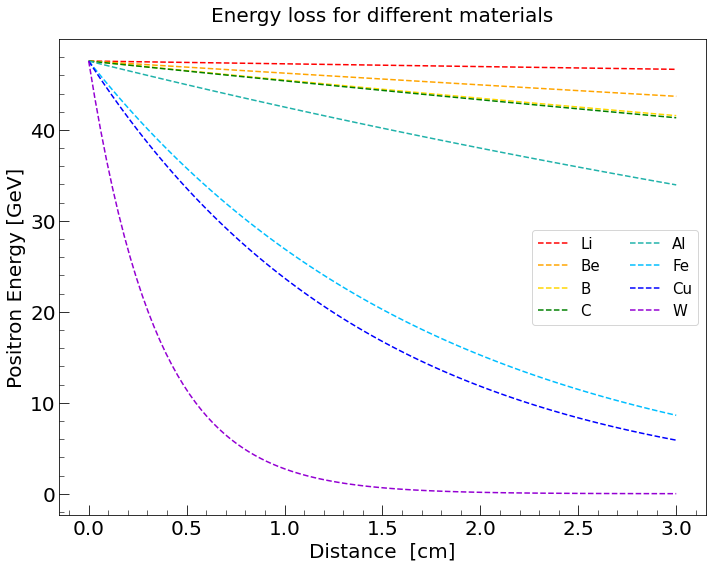

In [14]:

### Plot of energy loss or different materials ###
colors = ['red', 'orange', 'gold', 'green', 'lightseagreen', 'deepskyblue', 'blue', 'darkviolet']

x = np.linspace(0,3,100) # distances from 0 to 3 cm 

fig, ax = plt.subplots(1, figsize = (10,8))

for i in range(0,8):
    ax.plot(x, E_0th * np.exp(-x/properties.at[i,'X0'])* 1e-03,label = properties.at[i,'Material'], color = colors[i],ls='dashed')
    
ax.set_title('Energy loss for different materials' ,fontsize = 20, pad = 18)
ax.set_xlabel('Distance  [cm]',fontsize = 20)
ax.set_ylabel('Positron Energy [GeV]',fontsize = 20)                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()

ax.legend(loc='best', fontsize=15, ncol = 2)

fig.tight_layout()
plt.show()

# 9) Simulation with energy loss
We now take into account the loss of energy along the target when generating the events, both for a monochromatic and non-monochromatic beam. 


## 9.1 Monochromatic beam
From the previous point we have seen that the minimum positron energy required to have muon pairs production along the whole target, i.e. a non-zero
cross section, is equal to $ E_{0,th} \sim 47.6~\text{GeV} $. This value corresponds to an invariant mass $\sqrt{s} \sim 220.6$ MeV. So, in order
to satisty the aforementioned condition, we choose a CoM energy slightly greater, i.e. $\sqrt{s} = 225$ MeV, which corresponds to a positron 
initial energy E $_0 \sim 49.54~\text{GeV}$. The energy loss leads to a variable pair-production probability depending on the cross section along the target. 
We need to generate the position along the x-axis inside the target and then retrieve the angular distribution of the emitted muons in the CoM frame, 
using the **acceptance-rejection method**. So we'll proceed in the following way:

- we first need to compute the invariant mass depending on the initial energy $\text{E}_0$ and on the position $x$;
- then we compute the cross section, according to the initail energy and point of interaction;
- we divide the target into a range of discrete intervals in order to obtain the number of interactions in function of the travelled distance;
- knowing the total number of produced muon pairs (in one week), we can infer how many interactions occur in each slice of the target lenght  

In [15]:
def s_att(x,E0):
    '''
        Function that calculates s in function of the initial energy E_0
        and of the position x inside the target. 

        Parameters:
        x: position in the medium [cm]
        E0: initial positrons energy [MeV]

        Returns:
        s [MeV^2]
    '''

    return 2 * me**2 + 2 * E0 *np.exp(-x/rad_length) * me

def sigma_att(x,E0):
    '''
        Function that calculates the cross section in function of
        the initial energy E_0 and of the position x inside the target. 

        Parameters:
        x: position in the medium [cm]
        E0: initial positrons energy [MeV]

        Returns:
        sigma [] ### UNITÀ DI MISURA
    '''

    return sigma(s_att(x,E0))

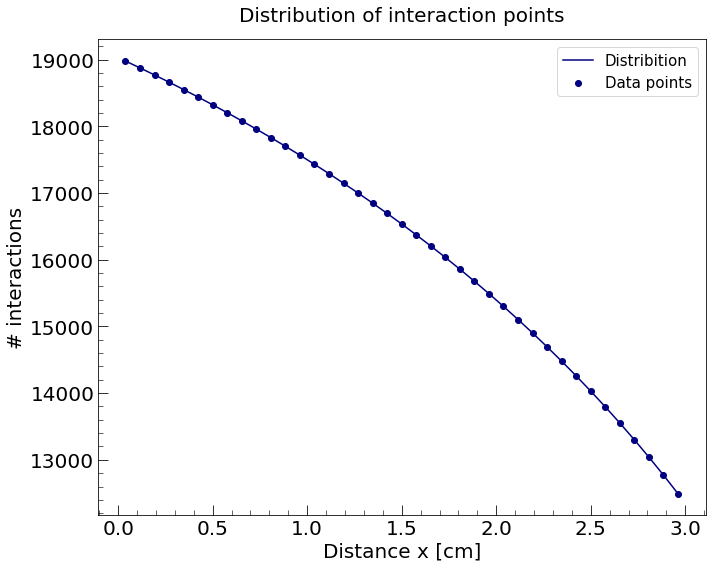

In [16]:
E_0 = 49.54 * 1000  # positrons initial energy [MeV]
n_grid = 40         # number of grid points 

scale = (l/n_grid) *  389.4 * 1e-24 * rho_electrons  # scaling factor and conversion from MeV^-2 to cm^2 

points = np.linspace(0,l,n_grid)            # array of grid points
points = (points[1:] + points [:-1]) / 2    # we take the middle point of each piece 

T     = 3600 * 24 * 7                       # seconds in a week
n_part_tot = T * 10**6                      # number of pairs produced in a week considering f = 10^6 Hz

particles = np.zeros(n_grid)                # initialize array to store number of particles in each interval
particles[0] = n_part_tot                   # initial number 

for i in range(n_grid-1):
    prob = 1 - scale * sigma_att(points[i],E_0)  # probability of not interacting -> used to calculate how many particles 
                                                 # can still interact after at a certain distance 
    particles[i+1] = particles[i] * prob  

n_interactions = particles[:-1] - particles[1:] # subtract the number of particles in interval [i] from the one in [i+1]

# normalize to total number of interactions 

fig, ax = plt.subplots(1, figsize = (10,8))

# use intep1d to find the distribution for the interaction points
dist = interp1d(points,n_interactions, fill_value ='extrapolate') 

# if we want to find the normalized ditribution we need to divide buìy the sum of the # of interactions  
# n_interactions_nor = n_interactions / n_interactions.sum()
# dist = interp1d(points,n_interactions,fill_value ='extrapolate")
                        
ax.plot(points, dist(points), color = 'navy',label = 'Distribition')
ax.scatter(points, n_interactions, marker = 'o', color = 'navy', label = 'Data points')

ax.set_title('Distribution of interaction points' ,fontsize = 20, pad = 18)
ax.set_xlabel('Distance x [cm]',fontsize = 20)
ax.set_ylabel('# interactions',fontsize = 20)                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()
ax.legend(loc='best', fontsize=15, ncol = 1)


fig.tight_layout()
plt.show()

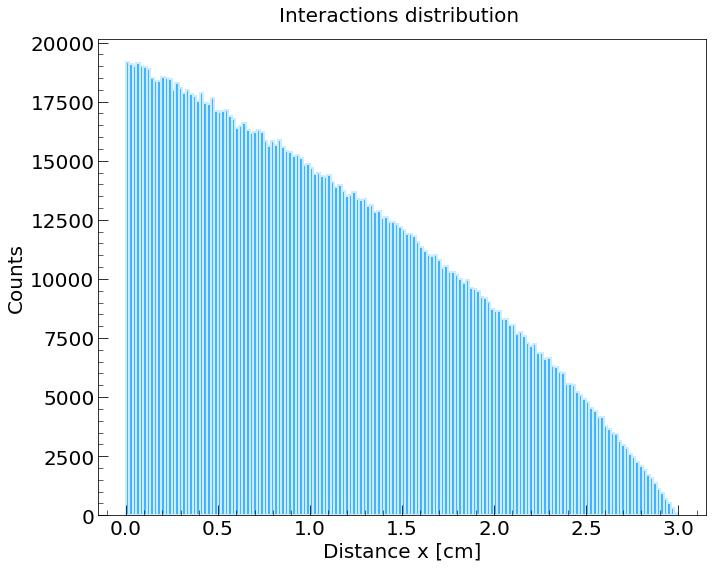

In [17]:
# accept-reject method according to the distribution above
accepted_events = []
N = 10**6

'''
Same result but way less efficient!!

while len(accepted_events) < N: 
    dist_points = np.random.uniform(0,l)
    check = np.random.uniform(dist(3),dist(0))
    if(check < dist(dist_points)):
        accepted_events.append(dist_points)
'''

dist_points = np.random.uniform(0, l, 3*N) 
check = np.random.uniform(dist(3), dist(0), 3*N)   
accepted_events = dist_points[check < dist(dist_points)]


fig, ax = plt.subplots(1, figsize = (10,8))

sns.histplot(x=accepted_events,
             ax=ax,
             stat='count',
             lw=2,
             edgecolor   = '#ccebff',
             color       = '#009CFF'
              )

ax.set_title('Interactions distribution ', fontsize = 20, pad = 18)
ax.set_xlabel('Distance x [cm]',fontsize = 20)

# plot settings   
ax.set_ylabel('Counts',fontsize = 20)                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()


fig.tight_layout()
plt.show()

In [18]:
# Apply accept-reject on previously accepted points according to cross section in each interval

# Generate angles in CoM frame 
angles = np.random.uniform(0, np.pi, len(accepted_events))
check_ang = np.random.uniform(0, ang(s_att(accepted_events, E_0),np.pi/2), len(accepted_events)) 

# create Dataframe 
df_energies_mono_att = pd.DataFrame(s_att(accepted_events, E_0), columns = ['Energy']) # s values of accepted events 
df_energies_mono_att['Angles'] = angles                                                
df_energies_mono_att['emission_point'] = accepted_events                               # column with interaction point 
df_energies_mono_att['check']  = check_ang

# accept only the events that satisfy the condition, i.e. follow the wanted distribution                                        
df_energies_mono_att[r'$\theta^*$']  = df_energies_mono_att.Angles[df_energies_mono_att.check < ang(df_energies_mono_att.Energy, df_energies_mono_att.Angles)] 
# drop columns with NaN -> events that do not follow the distribution 
df_energies_mono_att = df_energies_mono_att.dropna()
# keep only N events 
df_energies_mono_att = df_energies_mono_att.iloc[:N]

df_energies_mono_att

,Energy,Angles,emission_point,check,$\theta^*$
0,49984.213272,2.576435,0.453104,0.060495,2.576435
1,50123.659770,1.434371,0.354816,0.337043,1.434371
2,49965.235341,2.099943,0.466502,0.269025,2.099943
4,50057.777608,1.579044,0.401218,0.100476,1.579044
5,48823.571856,0.790242,1.281981,0.240921,0.790242
...,...,...,...,...,...
1546115,49092.356039,0.347483,1.088288,0.165455,0.347483
1546117,48661.926483,1.887470,1.398981,0.140046,1.887470
1546118,50493.116282,1.459329,0.095721,0.235341,1.459329
1546119,50247.507083,1.272828,0.267751,0.350135,1.272828


To simulate the events with different values of s, starting from `generate_beam`, we slightly modify the function
in order to give as input a DataFrame containing different energies.

In [19]:

def generate_beam_df(df):


    batch_size = df.shape[0]
    pnorm = norm(df.Energy) # Norm of muon 3-momentum in CM
    
    # Compute inverse CDF of g(theta*) by interpolation 
    theta_star = np.linspace(0, np.pi, N)
    inv_cdf = interp1d(g_cdf(df.Energy, theta_star), theta_star, fill_value='extrapolate')

    # Sample angles
    num_samples = N
    unif_samples = np.random.uniform(size=batch_size)

    phis = np.random.uniform(0, 2 * np.pi, size=batch_size)
    thetas = inv_cdf(unif_samples)
    
    
    # Compute cartesian components of 3-vector
    px_cm = pnorm * np.cos(df.Angles)
    py_cm = pnorm * np.sin(df.Angles) * np.cos(phis)
    pz_cm = pnorm * np.sin(df.Angles) * np.sin(phis)


    _,px1 = energy_x_boost(df.Energy, px_cm)  # px for first muon
    _,px2 = energy_x_boost(df.Energy, -px_cm) # px for second muon
    # py and pz are orthogonal to boost axis, and so they remain the same
    
    return np.stack((px1, py_cm, pz_cm, px2, -py_cm, -pz_cm), axis=1)    


# generate events 
events_att = generate_beam_df(df_energies_mono_att)
# save events in txt file and dataframe 
np.savetxt("Momenta_monochromatic_attenuated.txt", events_att) # save to file
df_monochromatic_att = pd.DataFrame(events_att, columns = [  '$px_{\mu_1}$','$py_{\mu_1}$','$pz_{\mu_1}$','$px_{\mu_2}$','$py_{\mu_2}$','$pz_{\mu_2}$'])
df_monochromatic_att.to_csv('Events_attenuated_mono.csv')
df_monochromatic_att


,$px_{\mu_1}$,$py_{\mu_1}$,$pz_{\mu_1}$,$px_{\mu_2}$,$py_{\mu_2}$,$pz_{\mu_2}$
0,17710.505415,-17.187487,-9.312785,31197.316244,17.187487,9.312785
1,25623.769853,2.846869,36.521621,23420.496801,-2.846869,-36.521621
2,20421.745011,-31.293598,3.166030,28467.507206,31.293598,-3.166030
3,24423.544858,-21.788713,-29.595814,24556.257709,21.788713,29.595814
4,28797.553527,18.588882,13.438810,18974.608836,-18.588882,-13.438810
...,...,...,...,...,...,...
999995,30807.050123,-11.278186,1.204295,17228.111002,11.278186,-1.204295
999996,21679.534864,-1.290153,-30.049569,25934.461447,1.290153,30.049569
999997,25637.272861,36.628584,-9.993670,23768.497972,-36.628584,9.993670
999998,26990.490124,-35.714020,1.478429,22174.958104,35.714020,-1.478429


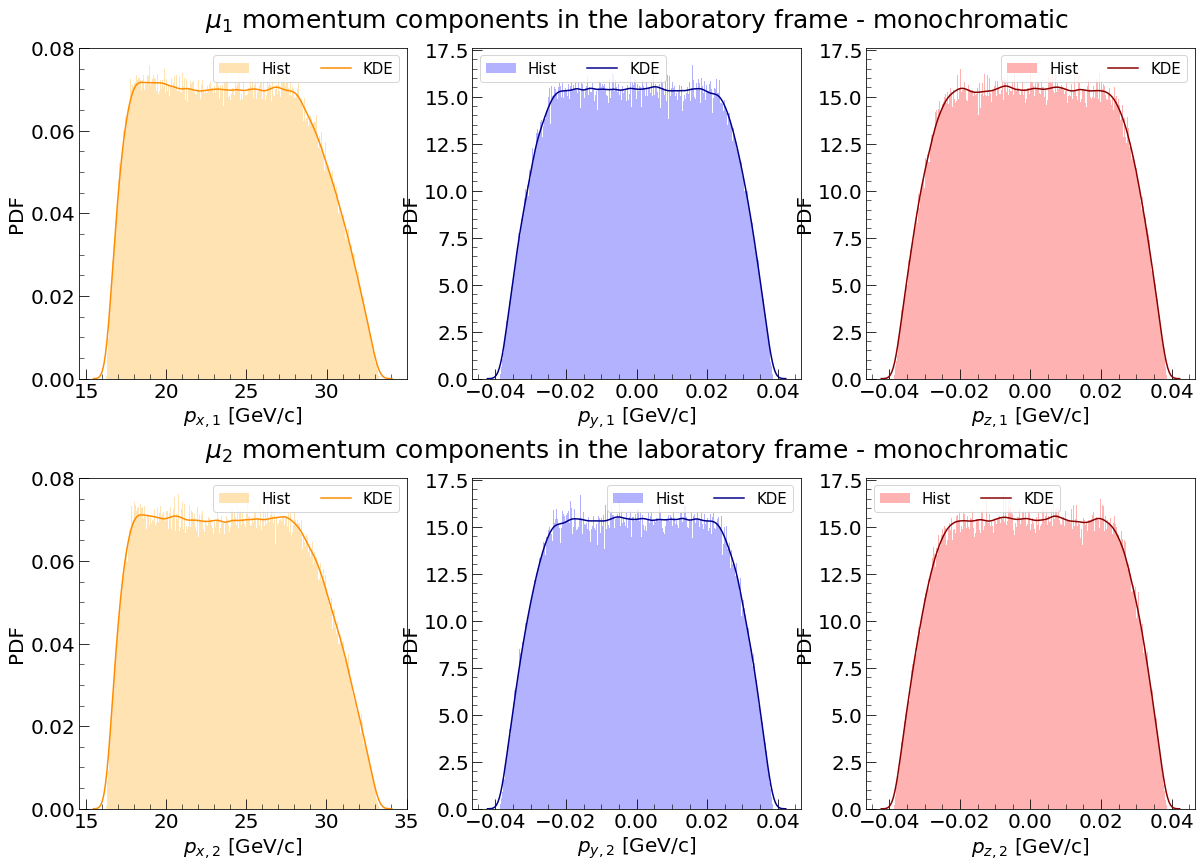

In [20]:
fig, ax = plt.subplots(2,3, figsize = (20,14))

# plotting momentum components distribution in the LAB frame


### MUON 1 ###
# px
sns.distplot(df_monochromatic_att['$px_{\mu_1}$']/1000,
             ax = ax[0][0],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkorange',   'label': 'KDE'},
             hist_kws = {'color': 'orange', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )

            
# py
sns.distplot(df_monochromatic_att['$py_{\mu_1}$']/1000,
             ax = ax[0][1],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkblue',   'label': 'KDE'},
             hist_kws = {'color': 'blue', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )
            
# pz
sns.distplot(df_monochromatic_att['$pz_{\mu_1}$']/1000,
             ax = ax[0][2],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkred',   'label': 'KDE'},
             hist_kws = {'color': 'red', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
            )


ax[0][0].set_xlabel(r'$p_{x,1}$ [GeV/c]',fontsize = 20)
ax[0][1].set_xlabel(r'$p_{y,1}$ [GeV/c]',fontsize = 20)
ax[0][2].set_xlabel(r'$p_{z,1}$ [GeV/c]',fontsize = 20)

ax[0][1].set_title('$\mu_1$ momentum components in the laboratory frame - monochromatic',fontsize = 25,pad = 20)


### MUON 2 ###
# px
sns.distplot(df_monochromatic_att['$px_{\mu_2}$']/1000,
             ax = ax[1][0],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkorange',   'label': 'KDE'},
             hist_kws = {'color': 'orange', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )
            
# py
sns.distplot(df_monochromatic_att['$py_{\mu_2}$']/1000,
             ax = ax[1][1],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws = {'color':'darkblue','label':'KDE'},
             hist_kws = {'color': 'blue', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )
            
# pz
sns.distplot(df_monochromatic_att['$pz_{\mu_2}$']/1000,
             ax = ax[1][2],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkred', 'label':'KDE'},
             hist_kws = {'color': 'red', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
            )


ax[1][0].set_xlabel(r'$p_{x,2}$ [GeV/c]',fontsize = 20)
ax[1][1].set_xlabel(r'$p_{y,2}$ [GeV/c]',fontsize = 20)
ax[1][2].set_xlabel(r'$p_{z,2}$ [GeV/c]',fontsize = 20)

ax[1][1].set_title('$\mu_2$ momentum components in the laboratory frame - monochromatic',fontsize = 25, pad = 20)

for ax in fig.get_axes():
    # plot settings   
    ax.set_ylabel('PDF',fontsize = 20)                   
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=15, ncol = 2)


plt.subplots_adjust(hspace=.3)
plt.show()

